In [1]:
import tensorflow as tf

In [2]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.models import Sequential

import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import pathlib


In [3]:
import os
data_path = pathlib.Path(r"C:\Users\Leela Krishna.Divi\Desktop\adata")


In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory(
 data_path,
 validation_split=0.2,
 subset="training",
 seed=123,
 image_size=(256,256),
 batch_size=32)


val_ds = tf.keras.utils.image_dataset_from_directory(
 data_path,
 validation_split=0.2,
 subset="validation",
 seed=123,
 image_size=(256,256),
 batch_size=32)

Found 5777 files belonging to 2 classes.
Using 4622 files for training.
Found 5777 files belonging to 2 classes.
Using 1155 files for validation.


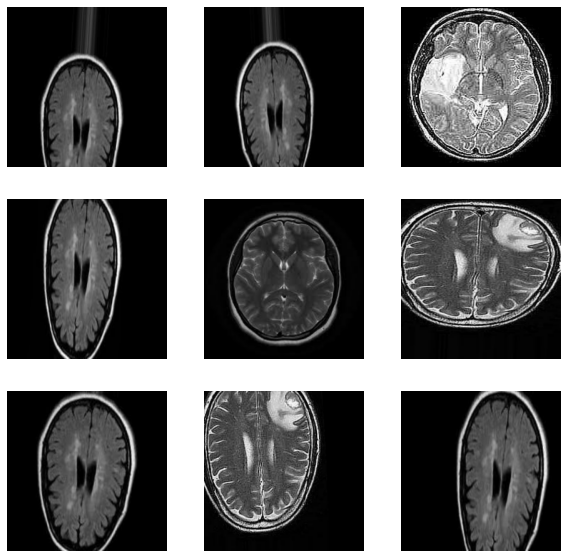

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
      for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")

In [6]:
from tensorflow.keras import layers
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(256,256),
  layers.Rescaling(1./255)
])

In [8]:
resnet_model = Sequential()

pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(256,256,3),
                   pooling='avg',classes=2,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

resnet_model.add(pretrained_model)

In [9]:
from tensorflow.keras.layers import Dropout
resnet_model.add(Flatten())
resnet_model.add(Dense(4096, activation='relu'))
resnet_model.add(Dropout(0.2))

resnet_model.add(Dense(1, activation='sigmoid'))

resnet_model.summary()



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 4096)              8392704   
                                                                 
 dropout (Dropout)           (None, 4096)              0         
                                                                 
 dense_1 (Dense)             (None, 1)                 4097      
                                                                 
Total params: 31,984,513
Trainable params: 8,396,801
Non-trainable params: 23,587,712
_________________________________________________________________


In [10]:
from keras.callbacks import ModelCheckpoint, EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
opt = Adam(learning_rate=0.001)
resnet_model.compile(loss='binary_crossentropy',optimizer=opt,metrics=['accuracy'])

early_stop= EarlyStopping(monitor='val_accuracy',patience=10,verbose=1,mode='auto')

mcp_save = ModelCheckpoint('mdl_resnt50_1.hdf5', save_best_only=True, mode='auto',period=1)



history=resnet_model.fit(train_ds,
          epochs=5,
          batch_size=32,
          validation_data=(val_ds), 
          callbacks=[early_stop,mcp_save])

Epoch 1/5
145/145 [==============================] - 1312s 9s/step - loss: 0.2761 - accuracy: 0.9310 - val_loss: 0.0609 - val_accuracy: 0.9801
Epoch 2/5
145/145 [==============================] - 1117s 8s/step - loss: 0.0580 - accuracy: 0.9792 - val_loss: 0.0882 - val_accuracy: 0.9671
Epoch 3/5
145/145 [==============================] - 1055s 7s/step - loss: 0.0620 - accuracy: 0.9766 - val_loss: 0.0330 - val_accuracy: 0.9896
Epoch 4/5
145/145 [==============================] - 1054s 7s/step - loss: 0.0344 - accuracy: 0.9877 - val_loss: 0.0292 - val_accuracy: 0.9905
Epoch 5/5
145/145 [==============================] - 1063s 7s/step - loss: 0.0330 - accuracy: 0.9890 - val_loss: 0.0238 - val_accuracy: 0.9931


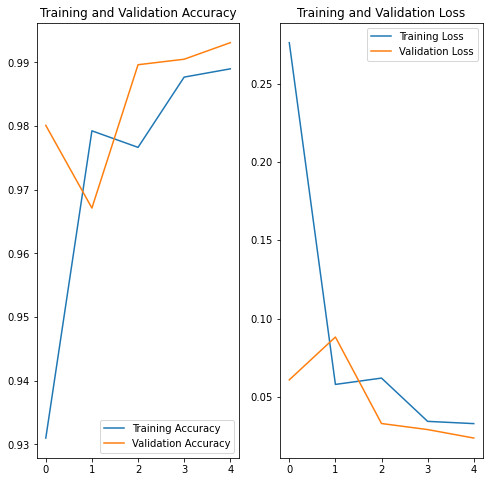

In [11]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()